In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
import random
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model,layers
from shutil import copyfile

random.seed(821)

import os
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

!kaggle datasets download -d arunrk7/surface-crack-detection
!unzip -q surface-crack-detection.zip



 95% 221M/233M [00:01<00:00, 172MB/s]
100% 233M/233M [00:01<00:00, 178MB/s]


In [ ]:
!kaggle datasets download -d keras/vgg16
!unzip -q vgg16.zip

 97% 525M/542M [00:03<00:00, 172MB/s]
100% 542M/542M [00:04<00:00, 141MB/s]


In [ ]:
!pip install opencv-python

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from matplotlib.image import imread
import cv2

In [ ]:
print(len(os.listdir("Positive")))
print(len(os.listdir("Negative")))

20000
20000


In [ ]:
os.mkdir('/tmp/concrete')
os.mkdir('/tmp/concrete/training')
os.mkdir('/tmp/concrete/testing')
os.mkdir('/tmp/concrete/valid')
os.mkdir('/tmp/concrete/training/positive')
os.mkdir('/tmp/concrete/training/negative')
os.mkdir('/tmp/concrete/testing/positive')
os.mkdir('/tmp/concrete/testing/negative')
os.mkdir('/tmp/concrete/valid/positive')
os.mkdir('/tmp/concrete/valid/negative')

In [ ]:
def split_data(SOURCE,TRAINING,VALID,TESTING,TRAINING_SIZE,VALID_SIZE):
    files=[]
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + "is zero length, so ignoring.")
    training_length = int(len(files)*TRAINING_SIZE)
    valid_length = int(len(files)*VALID_SIZE)
    testing_length = int(len(files)-training_length-valid_length)
    shuffled_set = random.sample(files,len(files))
    valid_set = shuffled_set[0:valid_length]
    training_set = shuffled_set[valid_length:-testing_length]
    testing_set = shuffled_set[-testing_length:]
    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file,destination)
    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALID + filename
        copyfile(this_file,destination)
    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file,destination)
        
POSITIVE_SOURCE_DIR = "/content/Positive/"
NEGATIVE_SOURCE_DIR = "/content/Negative/"
TRAINING_POSITIVE_DIR = '/tmp/concrete/training/positive/'  
TRAINING_NEGATIVE_DIR = '/tmp/concrete/training/negative/'   
VALID_POSITIVE_DIR = '/tmp/concrete/valid/positive/'  
VALID_NEGATIVE_DIR = '/tmp/concrete/valid/negative/'   
TESTING_POSITIVE_DIR = '/tmp/concrete/testing/positive/'
TESTING_NEGATIVE_DIR = '/tmp/concrete/testing/negative/'

training_size = 0.6
valid_size = 0.2
split_data(POSITIVE_SOURCE_DIR, TRAINING_POSITIVE_DIR, VALID_POSITIVE_DIR,TESTING_POSITIVE_DIR, training_size, valid_size)
split_data(NEGATIVE_SOURCE_DIR, TRAINING_NEGATIVE_DIR, VALID_NEGATIVE_DIR,TESTING_NEGATIVE_DIR, training_size, valid_size)

In [ ]:
print(len(os.listdir('/tmp/concrete/training/positive/')))
print(len(os.listdir('/tmp/concrete/training/negative/')))
print(len(os.listdir('/tmp/concrete/testing/positive/')))
print(len(os.listdir('/tmp/concrete/testing/negative/')))
print(len(os.listdir('/tmp/concrete/valid/positive/')))
print(len(os.listdir('/tmp/concrete/valid/negative/')))

12000
12000
4000
4000
4000
4000


In [ ]:
TRAINING_DIR = '/tmp/concrete/training/'
train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = 64, target_size = (227,227), class_mode = 'binary')
VALIDATION_DIR = '/tmp/concrete/valid/'
valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = 64, target_size = (227,227), class_mode = 'binary')

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [ ]:
TESTING_DIR = '/tmp/concrete/testing/'
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(TESTING_DIR, batch_size = 64, target_size = (227,227), class_mode = 'binary')

Found 8000 images belonging to 2 classes.


**첫 번째 vgg16**

- dropout = 0.1
- loss= 'binary_crossentropy'
- optimizer = Adam(lr=0.01)
- epoch = Earlystopping(minimize val_loss , patience= 10)
- metric = **recall**

In [ ]:
from tensorflow.keras.applications import VGG16

weights_file='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model=VGG16(input_shape = (227, 227, 3), 
                        include_top = False, 
                        weights =None)

pretrained_model.load_weights(weights_file)

for layer in pretrained_model.layers:
     layer.trainable = False

#pretrained_model.summary()

In [ ]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model_vgg = Model(pretrained_model.input, x) 


model_vgg.compile(optimizer = keras.optimizers.Adam(lr=0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])

model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)

mc_1=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)

history = model_vgg.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc_1]) # early_stopping

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 103s 181ms/step - loss: 1.6980 - recall: 0.9583 - val_loss: 0.0348 - val_recall: 0.9797
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 67s 177ms/step - loss: 0.0130 - recall: 0.9957 - val_loss: 0.0217 - val_recall: 0.9877
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/100
375/375 [==============================] - 67s 178ms/step - loss: 0.0456 - recall: 0.9908 - val_loss: 0.0410 - val_recall: 0.9780
Epoch 4/100
375/375 [==============================] - 67s 178ms/step - loss: 0.0104 - recall: 0.9959 - val_loss: 0.0146 - val_recall: 0.9960
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/100
375/375 [==============================] - 67s 178ms/step - loss: 0.0142 - recall: 0.9963 - val_loss: 0.0363 - val_recall: 0.9868
Epoch 6/100
375/375 [==============================] - 66s 177ms/step - loss: 0.0225 - recall: 0.9937 - val_loss: 0

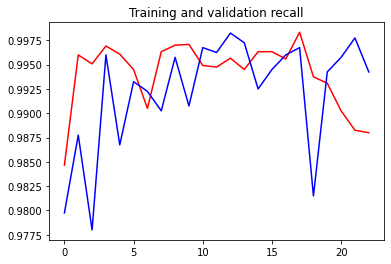

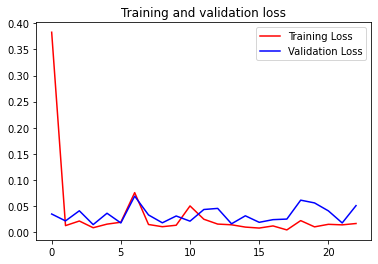

In [ ]:
import matplotlib.pyplot as plt

rec = history.history['recall']
val_rec = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(rec))

plt.plot(epochs, rec, 'r', label='Training recall')
plt.plot(epochs, val_rec, 'b', label='Validation recall')
plt.title('Training and validation recall')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

**두 번째 vgg16**

- dropout = 0.1
- loss= 'binary_crossentropy'
- optimizer = Adam(lr=0.1)
- epoch = Earlystopping(minimize val_loss , patience= 10)
- metric = recall

In [ ]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model_vgg2 = Model(pretrained_model.input, x) 


model_vgg2.compile(optimizer = keras.optimizers.Adam(lr=0.1), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])

model_vgg2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)

mc_2=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)

history_2 = model_vgg2.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc_2]) # early_stopping

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


375/375 [==============================] - 67s 177ms/step - loss: 107.7064 - recall: 0.9184 - val_loss: 0.9381 - val_recall: 0.9567
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 66s 176ms/step - loss: 1.3682 - recall: 0.9683 - val_loss: 0.0944 - val_recall: 0.9837
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/100
375/375 [==============================] - 67s 178ms/step - loss: 1.4824 - recall: 0.9722 - val_loss: 0.4890 - val_recall: 0.9072
Epoch 4/100
375/375 [==============================] - 67s 177ms/step - loss: 1.9235 - recall: 0.8857 - val_loss: 0.0670 - val_recall: 0.9855
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/100
375/375 [==============================] - 66s 177ms/step - loss: 0.4379 - recall: 0.9531 - val_loss: 0.1448 - val_recall: 0.9503
Epoch 6/100
375/375 [==============================] - 66s 177ms/step - loss: 0.4614 - recall: 0.8861 - val_loss: 0.5246 - val

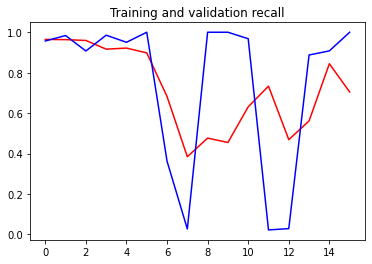

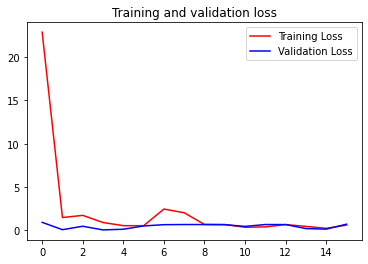

In [ ]:
import matplotlib.pyplot as plt

rec = history_2.history['recall']
val_rec = history_2.history['val_recall']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(rec))

plt.plot(epochs, rec, 'r', label='Training recall')
plt.plot(epochs, val_rec, 'b', label='Validation recall')
plt.title('Training and validation recall')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

**세번째 vgg16**

- dropout = 0.1
- loss= 'binary_crossentropy'
- optimizer = SGD(Momentum coef = 0.9, lr=0.1)
- epoch = Earlystopping(minimize val_loss , patience= 10)
- metric = recall

In [ ]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model_vgg3 = Model(pretrained_model.input, x) 


model_vgg3.compile(optimizer = keras.optimizers.SGD(lr=0.1, momentum=0.9), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])

model_vgg3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)

mc_3=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)

history_3 = model_vgg3.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc_3]) # early_stopping

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


375/375 [==============================] - 67s 177ms/step - loss: 1.6811 - recall: 0.4290 - val_loss: 0.6964 - val_recall: 1.0000
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 66s 177ms/step - loss: 0.6957 - recall: 0.6418 - val_loss: 0.6937 - val_recall: 1.0000
Epoch 3/100
375/375 [==============================] - 66s 176ms/step - loss: 0.6938 - recall: 0.5422 - val_loss: 0.6938 - val_recall: 1.0000
Epoch 4/100
375/375 [==============================] - 66s 176ms/step - loss: 0.6946 - recall: 0.3919 - val_loss: 0.6934 - val_recall: 1.0000
Epoch 5/100
375/375 [==============================] - 67s 178ms/step - loss: 0.6949 - recall: 0.5523 - val_loss: 0.6956 - val_recall: 1.0000
Epoch 6/100
375/375 [==============================] - 66s 177ms/step - loss: 0.6953 - recall: 0.5849 - val_loss: 0.6940 - val_recall: 1.0000
Epoch 7/100
375/375 [==============================] - 66s 176ms/step - loss: 0.6944 - recall: 0.5269 

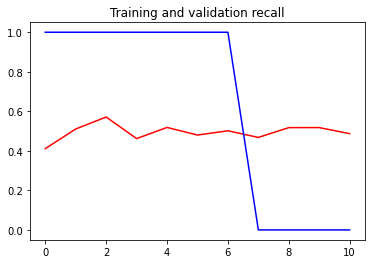

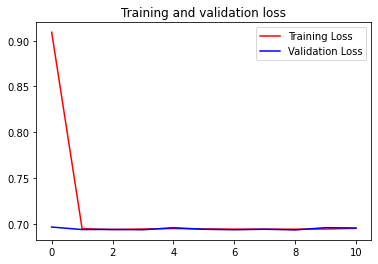

In [ ]:
import matplotlib.pyplot as plt

rec = history_3.history['recall']
val_rec = history_3.history['val_recall']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(rec))

plt.plot(epochs, rec, 'r', label='Training recall')
plt.plot(epochs, val_rec, 'b', label='Validation recall')
plt.title('Training and validation recall')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

네번째 vgg16

- dropout = 0.1
- loss= 'binary_crossentropy'
- optimizer = SGD(Momentum coef = 0.9, lr=0.01)
- epoch = Earlystopping(minimize val_loss , patience= 10)
- metric = recall

기존

In [ ]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model_vgg4 = Model(pretrained_model.input, x) 


model_vgg4.compile(optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])

model_vgg4.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)

mc_4=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)

history_4 = model_vgg4.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc_4]) # early_stopping

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - 170s 341ms/step - loss: 0.3450 - recall: 0.8581 - val_loss: 0.0322 - val_recall: 0.9925
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
375/375 [==============================] - 129s 344ms/step - loss: 0.0310 - recall: 0.9900 - val_loss: 0.0257 - val_recall: 0.9865
Epoch 3/100
375/375 [==============================] - 129s 345ms/step - loss: 0.0305 - recall: 0.9891 - val_loss: 0.0244 - val_recall: 0.9862
Epoch 4/100
375/375 [==============================] - 129s 344ms/step - loss: 0.0291 - recall: 0.9888 - val_loss: 0.0184 - val_recall: 0.9945
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/100
375/375 [==============================] - 129s 344ms/step - loss: 0.0203 - recall: 0.9925 - val_loss: 0.0181 - val_recall: 0.9912
Epoch 6/100
375/375 [==============================] - 129s 344ms/step - loss: 0.0172 - recall: 0.9943 - val_loss: 0.0161 - val_recall: 0.9950
INFO:tensorflow:Assets wri

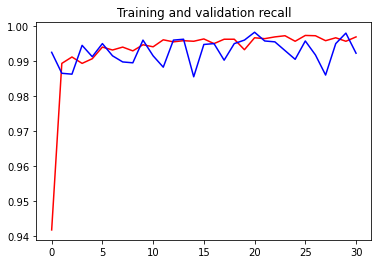

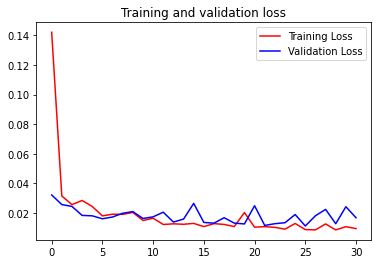

In [ ]:
import matplotlib.pyplot as plt

rec = history_4.history['recall']
val_rec = history_4.history['val_recall']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(rec))

plt.plot(epochs, rec, 'r', label='Training recall')
plt.plot(epochs, val_rec, 'b', label='Validation recall')
plt.title('Training and validation recall')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

체크포인트 저장

In [ ]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model_vgg4_test = Model(pretrained_model.input, x) 


model_vgg4_test.compile(optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])

model_vgg4_test.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpoint_path = 'here/checkpoint-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_dir)

# checkpoint_path 포맷을 사용하는 가중치를 저장
model_vgg4_test.save_weights(checkpoint_path.format(epoch=0))
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model_vgg4_test = Model(pretrained_model.input, x) 


model_vgg4_test.compile(optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])

model_vgg4_test.summary()

early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10) # patience 우선은 2 -> 10
mc_4=ModelCheckpoint(filepath = checkpoint_path, monitor='val_recall', mode='max', save_weights_only=True)

history_test = model_vgg4_test.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc_4]) # early_stopping

here
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1500/1500 [==============================] - 140s 93ms/step - loss: 0.3297 - recall: 0.8499 - val_loss: 0.0518 - val_recall: 0.9902
Epoch 2/100
1500/1500 [==============================] - 139s 92ms/step - loss: 0.1041 - recall: 0.9719 - val_loss: 0.0250 - val_recall: 0.9880
Epoch 3/100
1500/1500 [==============================] - 139s 92ms/step - loss: 0.0989 - recall: 0.9612 - val_loss: 0.0205 - val_recall: 0.9918
Epoch 4/100
1500/1500 [==============================] - 138s 92ms/step - loss: 0.0954 - recall: 0.9666 - val_loss: 0.0257 - val_recall: 0.9895
Epoch 5/100
1500/1500 [==============================] - 138s 92ms/step - loss: 0.0957 - recall: 0.9584 - val_loss: 0.0211 - val_recall: 0.9970
Epoch 6/100
1500/1500 [==============================] - 138s 92ms/step - loss: 0.0888 - recall: 0.9893 - val_loss: 0.0185 - val_recall: 0.9965
Epoch 7/100
1500/1500 [==============================] - 138s 92ms/step - loss: 0.0856 - recall: 0.9481 - val_loss: 0.0233 - val_recall: 0.9975
Epoc

In [ ]:
ls {checkpoint_dir}

checkpoint
checkpoint-0000.ckpt.data-00000-of-00001
checkpoint-0000.ckpt.index
checkpoint-0001.ckpt.data-00000-of-00001
checkpoint-0001.ckpt.index
checkpoint-0002.ckpt.data-00000-of-00001
checkpoint-0002.ckpt.index
checkpoint-0003.ckpt.data-00000-of-00001
checkpoint-0003.ckpt.index
checkpoint-0004.ckpt.data-00000-of-00001
checkpoint-0004.ckpt.index
checkpoint-0005.ckpt.data-00000-of-00001
checkpoint-0005.ckpt.index
checkpoint-0006.ckpt.data-00000-of-00001
checkpoint-0006.ckpt.index
checkpoint-0007.ckpt.data-00000-of-00001
checkpoint-0007.ckpt.index
checkpoint-0008.ckpt.data-00000-of-00001
checkpoint-0008.ckpt.index
checkpoint-0009.ckpt.data-00000-of-00001
checkpoint-0009.ckpt.index
checkpoint-0010.ckpt.data-00000-of-00001
checkpoint-0010.ckpt.index
checkpoint-0011.ckpt.data-00000-of-00001
checkpoint-0011.ckpt.index
checkpoint-0012.ckpt.data-00000-of-00001
checkpoint-0012.ckpt.index
checkpoint-0013.ckpt.data-00000-of-00001
checkpoint-0013.ckpt.index
checkpoint-0014.ckpt.data-00000-of-00

In [ ]:
# 마지막 체크포인트 확인
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'here/checkpoint-0017.ckpt'

In [ ]:

model_vgg4_test.load_weights('here/checkpoint-0007.ckpt')

result = model_vgg4_test.evaluate(test_generator)

print(result)

125/125 [==============================] - 32s 251ms/step - loss: 0.0227 - recall: 0.9995
[0.022658726200461388, 0.9994999766349792]


다섯 번째 vgg16

- dropout = 0.1
- loss= 'binary_crossentropy'
- optimizer = Minibatch SGD(batch_size=16, lr=0.01)
- epoch = Earlystopping(minimize val_loss , patience= 10)
- metric = recall

In [ ]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model_vgg5 = Model(pretrained_model.input, x) 


model_vgg5.compile(optimizer = keras.optimizers.SGD(lr=0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])

model_vgg5.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
TRAINING_DIR = '/tmp/concrete/training/'
train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = 16, target_size = (227,227), class_mode = 'binary')
VALIDATION_DIR = '/tmp/concrete/valid/'
valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = 16, target_size = (227,227), class_mode = 'binary')

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)

mc_5=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)

history_5 = model_vgg5.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc_5]) # early_stopping

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1500/1500 [==============================] - 141s 92ms/step - loss: 0.3096 - recall: 0.8988 - val_loss: 0.0276 - val_recall: 0.9902
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
1500/1500 [==============================] - 137s 91ms/step - loss: 0.0391 - recall: 0.9850 - val_loss: 0.0273 - val_recall: 0.9840
Epoch 3/100
1500/1500 [==============================] - 137s 91ms/step - loss: 0.0303 - recall: 0.9883 - val_loss: 0.0210 - val_recall: 0.9895
Epoch 4/100
1500/1500 [==============================] - 137s 92ms/step - loss: 0.0251 - recall: 0.9905 - val_loss: 0.0330 - val_recall: 0.9818
Epoch 5/100
1500/1500 [==============================] - 138s 92ms/step - loss: 0.0237 - recall: 0.9925 - val_loss: 0.0173 - val_recall: 0.9925
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 6/100
1500/1500 [==============================] - 138s 92ms/step - loss: 0.0223 - recall: 0.9918 - val_loss: 0.0196 - val_recall: 0.9895
Epoch 7/100
1500/150

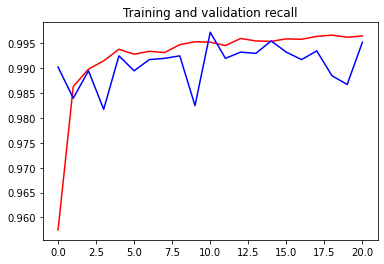

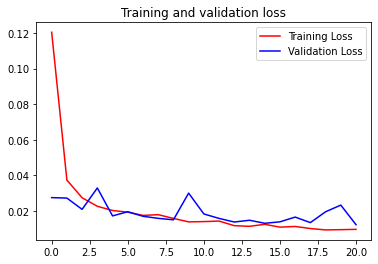

In [ ]:
import matplotlib.pyplot as plt

rec = history_5.history['recall']
val_rec = history_5.history['val_recall']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(len(rec))

plt.plot(epochs, rec, 'r', label='Training recall')
plt.plot(epochs, val_rec, 'b', label='Validation recall')
plt.title('Training and validation recall')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()

여섯 번째 vgg16

- dropout = 0.1
- loss= 'binary_crossentropy'
- optimizer = Minibatch SGD(batch_size=16, lr=0.1)
- epoch = Earlystopping(minimize val_loss , patience= 10)
- metric = recall

In [ ]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model_vgg6 = Model(pretrained_model.input, x) 


model_vgg6.compile(optimizer = keras.optimizers.SGD(lr=0.1), 
              loss = 'binary_crossentropy', 
              metrics = ['Recall'])

model_vgg6.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
TRAINING_DIR = '/tmp/concrete/training/'
train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = 16, target_size = (227,227), class_mode = 'binary')
VALIDATION_DIR = '/tmp/concrete/valid/'
valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = 16, target_size = (227,227), class_mode = 'binary')

Found 24000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)

mc_6=ModelCheckpoint('/tmp/checkpoint', monitor='val_recall', mode='max', save_best_only=True)

history_6 = model_vgg6.fit_generator(train_generator,
            validation_data = valid_generator,
            epochs = 100,
            verbose = 1,
            callbacks=[early_stopping, mc_6]) # early_stopping

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1500/1500 [==============================] - 138s 91ms/step - loss: 1.0278 - recall: 0.3866 - val_loss: 0.6931 - val_recall: 2.5000e-04
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/100
1500/1500 [==============================] - 137s 91ms/step - loss: 0.6935 - recall: 0.4716 - val_loss: 0.6931 - val_recall: 2.5000e-04
Epoch 3/100
1500/1500 [==============================] - 137s 91ms/step - loss: 0.6936 - recall: 0.4015 - val_loss: 0.6931 - val_recall: 2.5000e-04
Epoch 4/100
1500/1500 [==============================] - 137s 91ms/step - loss: 0.6936 - recall: 0.4689 - val_loss: 0.6935 - val_recall: 0.0000e+00
Epoch 5/100
1500/1500 [==============================] - 137s 91ms/step - loss: 0.6937 - recall: 0.4270 - val_loss: 0.6932 - val_recall: 0.0000e+00
Epoch 6/100
1500/1500 [==============================] - 137s 91ms/step - loss: 0.6936 - recall: 0.5917 - val_loss: 0.6936 - val_recall: 0.0000e+00
Epoch 7/100
1500/1500 [==============================] - 137s 91ms

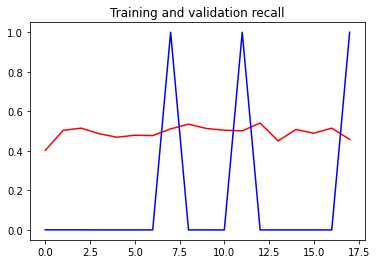

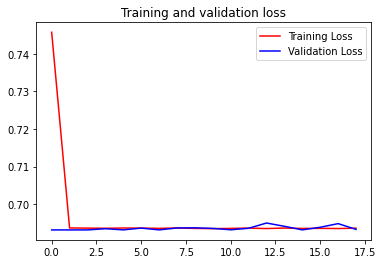

In [ ]:
import matplotlib.pyplot as plt

rec = history_6.history['recall']
val_rec = history_6.history['val_recall']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(len(rec))

plt.plot(epochs, rec, 'r', label='Training recall')
plt.plot(epochs, val_rec, 'b', label='Validation recall')
plt.title('Training and validation recall')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')

plt.legend()

plt.show()